In [1]:
import os

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

import pickle
from matplotlib import pyplot as plt

## 2. FGSM

- 在Task1中，你已经完成了一个LeNet5模型的训练；接下来，请你在少量样本上实现对该模型的FGSM攻击

- 具体实验步骤如下：
  
  1. 将代码文件上传到服务器端根目录，保证你已经完成了Task1且model/目录中存有训练好的模型参数；
  
  2. 在服务器端根目录下新建目录data，并将样本数据（Week567_img_label.pkl）上传至data/目录下；
  
  3. 依照提示，完成Python文件中`fgsm(imgs, epsilon, model, criterion, labels)`函数的两个TODO内容：
     - 根据模型对给定样本的预测结果计算loss，并回传、方便梯度获取 
     - FGSM对抗样本生成过程，实现：$\tilde{x}=x+\epsilon\cdot \text{sign}(\nabla_x \ell(f_\theta(x),y))$
        - 助教测试时要求$\epsilon = 0.2$
        - 最后需要记得将生成的对抗样本clip到图片合法值域范围内（[0, 1]）
  
  4. 执行代码完成攻击与效果验证；
     - **正确实现要求对抗样本的匹配率低于0.4**。

In [2]:
from Week567_General_Code_Question import LeNet5, fgsm, evaluate
from Week567_General_Code_Question import visualize_benign, visualize_adv

### 目标模型加载

In [3]:
model = LeNet5()
model.load_state_dict(torch.load('model/lenet5.pt'))
model.eval()

criterion = nn.CrossEntropyLoss()

C:\Users\w2213\AppData\Local\Temp\ipykernel_18408\521520284.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model/lenet5.pt'))


### 读入待攻击的样本

再次提醒，在服务器端根目录下新建目录data，并将样本数据（Week567_img_label.pkl）上传至data/目录下

In [4]:
with open('data_fgsm/Week567_img_label.pkl', 'rb') as f:
    data = pickle.load(f)
    imgs, labels = data['img'], data['label']

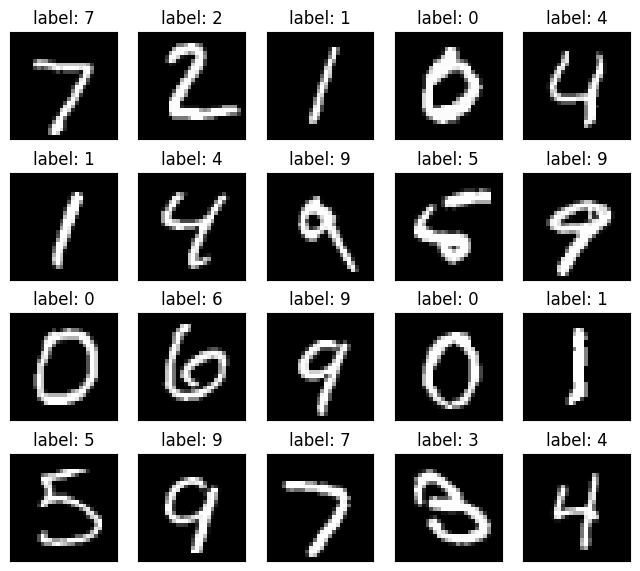

In [5]:
visualize_benign(imgs, labels)

### 实施FGSM生成对抗样本

请你在文件Week567_General_Code_Question.py的`fgsm(imgs, epsilon, model, criterion, labels)`函数中实现两个TODO内容：
- 根据模型对给定样本的预测结果计算loss，并回传、方便梯度获取 
- FGSM对抗样本生成过程，实现：$\tilde{x}=x+\epsilon\cdot \text{sign}(\nabla_x \ell(f_\theta(x),y))$
  - 助教测试时要求$\epsilon = 0.2$
  - 最后需要记得将生成的对抗样本clip到图片合法值域范围内（[0, 1]）

下面是一些供你参考/可能用到的API函数：

- torch.Tensor.requires_grad [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html)
  - 设置tensor是否加入计算图，即是否需要反向累积梯度
- torch.Tensor.grad [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.grad.html)
  - 在loss.backward()后，获取tensor上的梯度
- torch.Tensor.sign() [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.sign.html)
  - 取一个tensor中每个元素的符号（正负1），返回的形状与输入相同
- torch.clamp(*input*, *min=None*, *max=None*, ***, *out=None*) [Link](https://pytorch.org/docs/stable/generated/torch.clamp.html)
  - input: 需要clip的tensor
  - min, max: 截断的阈值，使tensor中在[min, max]以外的值被截断至min或max
- torch.Tensor.detach() [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html)
  - 获取一个脱离计算图的tensor，获得的tensor不再会被反向计算梯度


In [6]:
# perform fgsm attack and evaluate
epsilon = 0.2
adv_xs = fgsm(imgs, epsilon, model, criterion, labels)

### 评测对抗样本的攻击效果

请你在文件Week567_General_Code_Question.py的`evaluate(imgs, labels, model)`函数中实现下述TODO内容：

evaluate()函数评估模型对样本adv_xs的预测结果与真实标签labels的匹配率。该匹配率越低，则攻击效果越好。**正确实现要求对抗样本的匹配率低于0.4**。

- torch.argmax(*input*, *dim*, *keepdim=False*) [Link](https://pytorch.org/docs/stable/generated/torch.argmax.html)
  - input: 计算基于的tensor
  - dim: 希望按哪个维度求max下标
- torch.Tensor.item() [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.item.html)
  - 获取单元素tensor的标准python格式值

In [7]:
pred_label = evaluate(adv_xs, labels, model)

match rate: 0.15


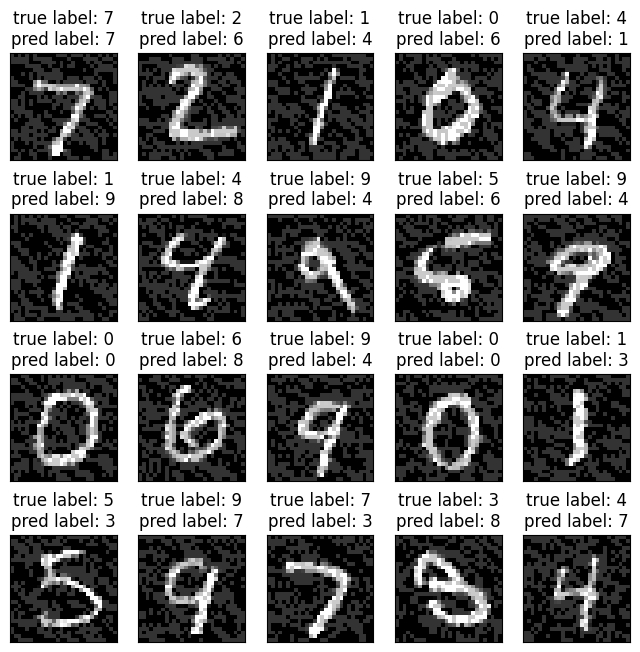

In [8]:
adv_imgs = adv_xs.reshape_as(imgs)
visualize_adv(adv_imgs, labels, pred_label)

In [9]:
with open('data/fgsm_img_label.pkl', 'wb') as f:
    pickle.dump({
        'adv_img': adv_imgs,
        'true_label': labels,
        'pred_label': pred_label,
    }, f)